In [1]:
import pandas as pd
import sqlite3

# Read Data from `Matched Sentences` and `Split Sentences` DBs

### Example: Get all edited sentences that differ more than a little bit

Often, when I wanted to merging information from the different SQLite3 databases, I couldn't do it as a large SQL command (SQLite3 would stall out). So, here is a helper script showing a workaround to generate keys in-memory and use these to filter from different databases.

In [2]:
# first, download and gunzip the files into the expected folder.

conn = sqlite3.connect('data/ap-matched-sentences.db')

In [3]:
# 1. get the sentence pairs with avg_sentence_distance_x > 0.1 AND avg_sentence_distance_y > 0.1
matched_df = pd.read_sql('''
    SELECT entry_id, version_x, version_y, sent_idx_x, sent_idx_y, avg_sentence_distance_x, avg_sentence_distance_y
        FROM matched_sentences m
    WHERE (avg_sentence_distance_x > 0.1) AND (avg_sentence_distance_y > 0.1)
''', con=conn)

# 2. get unique set of entries/versions as as flatmap
unique_v = (
    matched_df[['entry_id', 'version_x', 'sent_idx_x']]
     .rename(columns={'version_x': 'version', 'sent_idx_x': 'sent_idx'})
     .merge(right=matched_df[['entry_id', 'version_y', 'sent_idx_y']].rename(columns={'version_y': 'version', 'sent_idx_y': 'sent_idx'}),
            left_on=['entry_id', 'version', 'sent_idx'],
            right_on=['entry_id', 'version', 'sent_idx'],
            how='outer'
           )
)

# 3. dump unique (entry_id, version, sent_idx) strings as lookup-keys
keys = unique_v.apply(lambda x: '%s-%s-%s' % (int(x['entry_id']), int(x['version']), int(x['sent_idx'])), axis=1)

# 4. select all the sentences that match the desired generated keys
sentences = pd.read_sql('''
    WITH c1 as ( 
        SELECT *, 
        CAST(entry_id AS INT) || '-' || CAST(version AS INT) || '-' || CAST(version AS INT) as key
        FROM split_sentences
        )
        SELECT entry_id, version, sent_idx, sentence
        FROM c1
        WHERE key in (%s)
''' % ', '.join(map(lambda x: "'%s'" % x, keys)), con=conn)

# 5. merge retrieved sentences into the original DF
matched_df_with_sentences = (
    matched_df
     .merge(sentences, left_on=['entry_id', 'version_x', 'sent_idx_x'], right_on=['entry_id', 'version', 'sent_idx'])
     .drop(['version', 'sent_idx'], axis=1)
     .merge(sentences, left_on=['entry_id', 'version_y', 'sent_idx_y'], right_on=['entry_id', 'version', 'sent_idx']) 
     .drop(['version', 'sent_idx'], axis=1) 
)

In [4]:
matched_df_with_sentences.head()

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y,sentence_x,sentence_y
0,4212,0,1,0.0,0.0,0.419282,0.419282,<p> LONDON (AP) -- The British Department of T...,<p> LONDON (AP) -- Britain on Friday eased a b...
1,3800,5,6,26.0,21.0,0.414978,0.411659,</p> <p>Neither USA Hockey nor the players wou...,"An attorney for the players, John Langel, call..."
2,4040,1,2,67.0,56.0,0.333556,0.333556,</p> <p>Breslin had two daughters and four son...,""" Koch died in 2013.</p> <p>Breslin had two da..."
3,4242,0,1,22.0,23.0,0.229431,0.229431,"</p> <p>""He's just one of those people that yo...","</p> <p>""He's just one of those people that yo..."
4,3629,0,1,14.0,15.0,0.139025,0.139025,</p> <p>Children across the country are at ris...,</p> <p>Children across the country are at ris...


# Visualize Sentences

Visualizing individual sentences is lightweight, unlike visualizing documents, so we can just view it directly in the IPython notebook. We've written a small helper script to process and show word-level differences, called `html_compare_sentences`. This relies on Python's `difflib` package just for syntax highlighting, so please be aware that the visualization differences may not directly correspond to the `dist(x), dist(y)` columns, as they use different algorithms.

In [83]:
import sys
sys.path.insert(0, '..')
import util.util_newssniffer_parsing as up
from IPython.display import HTML, display

In [113]:
output_html = '''
    <table>
        <tr>
            <td>entry id</td>
            <td>version x</td>
            <td>sent idx x</td>
            <td>sentence x</td>
            <td>dist(x)</td>
            <td>dist(y)</td>
            <td>sentence y</td>
            <td>version y</td>
            <td>sent idx y</td>
        </tr>
        %s
    </table>
'''
output_rows = []
for e, v_x, v_y, s_idx_x, s_idx_y, d_x, d_y, s_x, s_y in matched_df_with_sentences.head(5).itertuples(index=False):
    html_x, html_y = up.html_compare_sentences(s_x, s_y)
    html_row = f'''
        <tr>
            <td>{e}</td>
            <td>{int(v_x)}</td>
            <td>{int(s_idx_x)}</td>
            <td>{html_x}</td>
            <td>{round(d_x, 2)}</td>
            <td>{round(d_y, 2)}</td>
            <td>{html_y}</td>
            <td>{int(s_idx_y)}</td>            
            <td>{int(v_y)}</td>
        </tr>
    '''
    output_rows.append(html_row)

output_html = output_html % ''.join(output_rows)

In [114]:
display(HTML(output_html))

entry id,version x,sent idx x,sentence x,dist(x),dist(y),sentence y,version y,sent idx y
4212,0,0,< p > LONDON ( AP ) -- The British Department of Transport says a ban on laptops and tablets being brought into airline cabins on certain flights must be put in place by Saturday .,0.42,0.42,"< p > LONDON ( AP ) -- Britain on Friday eased a ban on laptops and tablets in airline cabins , lifting the prohibition on some flights from Turkey .",0,1
3800,5,26,< /p > < p > Neither USA Hockey nor the players would reveal details of the wages in dispute or how the men 's team is compensated .,0.41,0.41,"An attorney for the players , John Langel , called the gap a "" chasm . "" > < p > Neither USA Hockey nor the players have revealed details of the wages in dispute or how the men 's team is compensated .",21,6
4040,1,67,"< /p > < p > Breslin had two daughters and four sons with his first wife , Rosemary , who died of cancer in 1981 .",0.33,0.33,""" Koch died in 2013. > < p > Breslin had two daughters and four sons with his first wife , Rosemary , who died of cancer in 1981 .",56,2
4242,0,22,"< /p > < p>""He 's just one of those people that you wish you never met , "" said Marcus Dagan .",0.23,0.23,"< /p > < p>""He 's just one of those people that you wish you never met , "" said Marcus Dagan , who had been informally managing the building on behalf of its then - owner and took Jackson to court over the rent .",23,1
3629,0,14,< /p > < p > Children across the country are at risk of severe injury while playing around landmines and cluster munitions .,0.14,0.14,< /p > < p > Children across the country are at risk of severe injury while playing around land mines and cluster munitions .,15,1


# Visualize Entire Documents

Visualizing the entire document is a little more complex, so it's easier to view it as a separate HTML. We've made helpers for you that will do that. In this section, we'll process and dump the file into a Jinja HTML template for you to look at.

In [115]:
import util.util_data_fetching_for_app as uda
from jinja2 import Template, Environment, FileSystemLoader
import datetime
from IPython.display import display, HTML

# 1. set up the Jinja environment and select the template we will write to
jinja_env = Environment(loader=FileSystemLoader('../evaluation/templates'))
template = jinja_env.get_template('visualize-doc-level-edits.html')

# 2. select one target article and do some processing
one_article_matched_df = pd.read_sql('''
    SELECT * FROM matched_sentences 
    WHERE entry_id = 167 AND version_x = 0 AND version_y = 1
''', con=conn).assign(source='ap')

one_article_sentences_df = (
    pd.read_sql('''SELECT * from split_sentences where entry_id = 167''', con=conn)
        .assign(source='ap')
)

data_to_render = uda.match_sentences(one_article_matched_df, one_article_sentences_df)
data_dict_for_rendering = uda.dump_output_to_app_readable(data_to_render)
one_key = list(data_dict_for_rendering.keys())[0]
one_doc_to_render = data_dict_for_rendering[one_key]

# 3. write to the template, generating a full HTML file, and write this to disk
html = template.render(
    data=one_doc_to_render,
    doc_id=one_key,
    do_mturk=False,
    start_time=str(datetime.datetime.now()),
)

with open('test-html.html', 'w') as f:
    f.write(html)

In [ ]:
# now, open in a browser window by doing the following:
! open test-html.html

This will show us something like this:

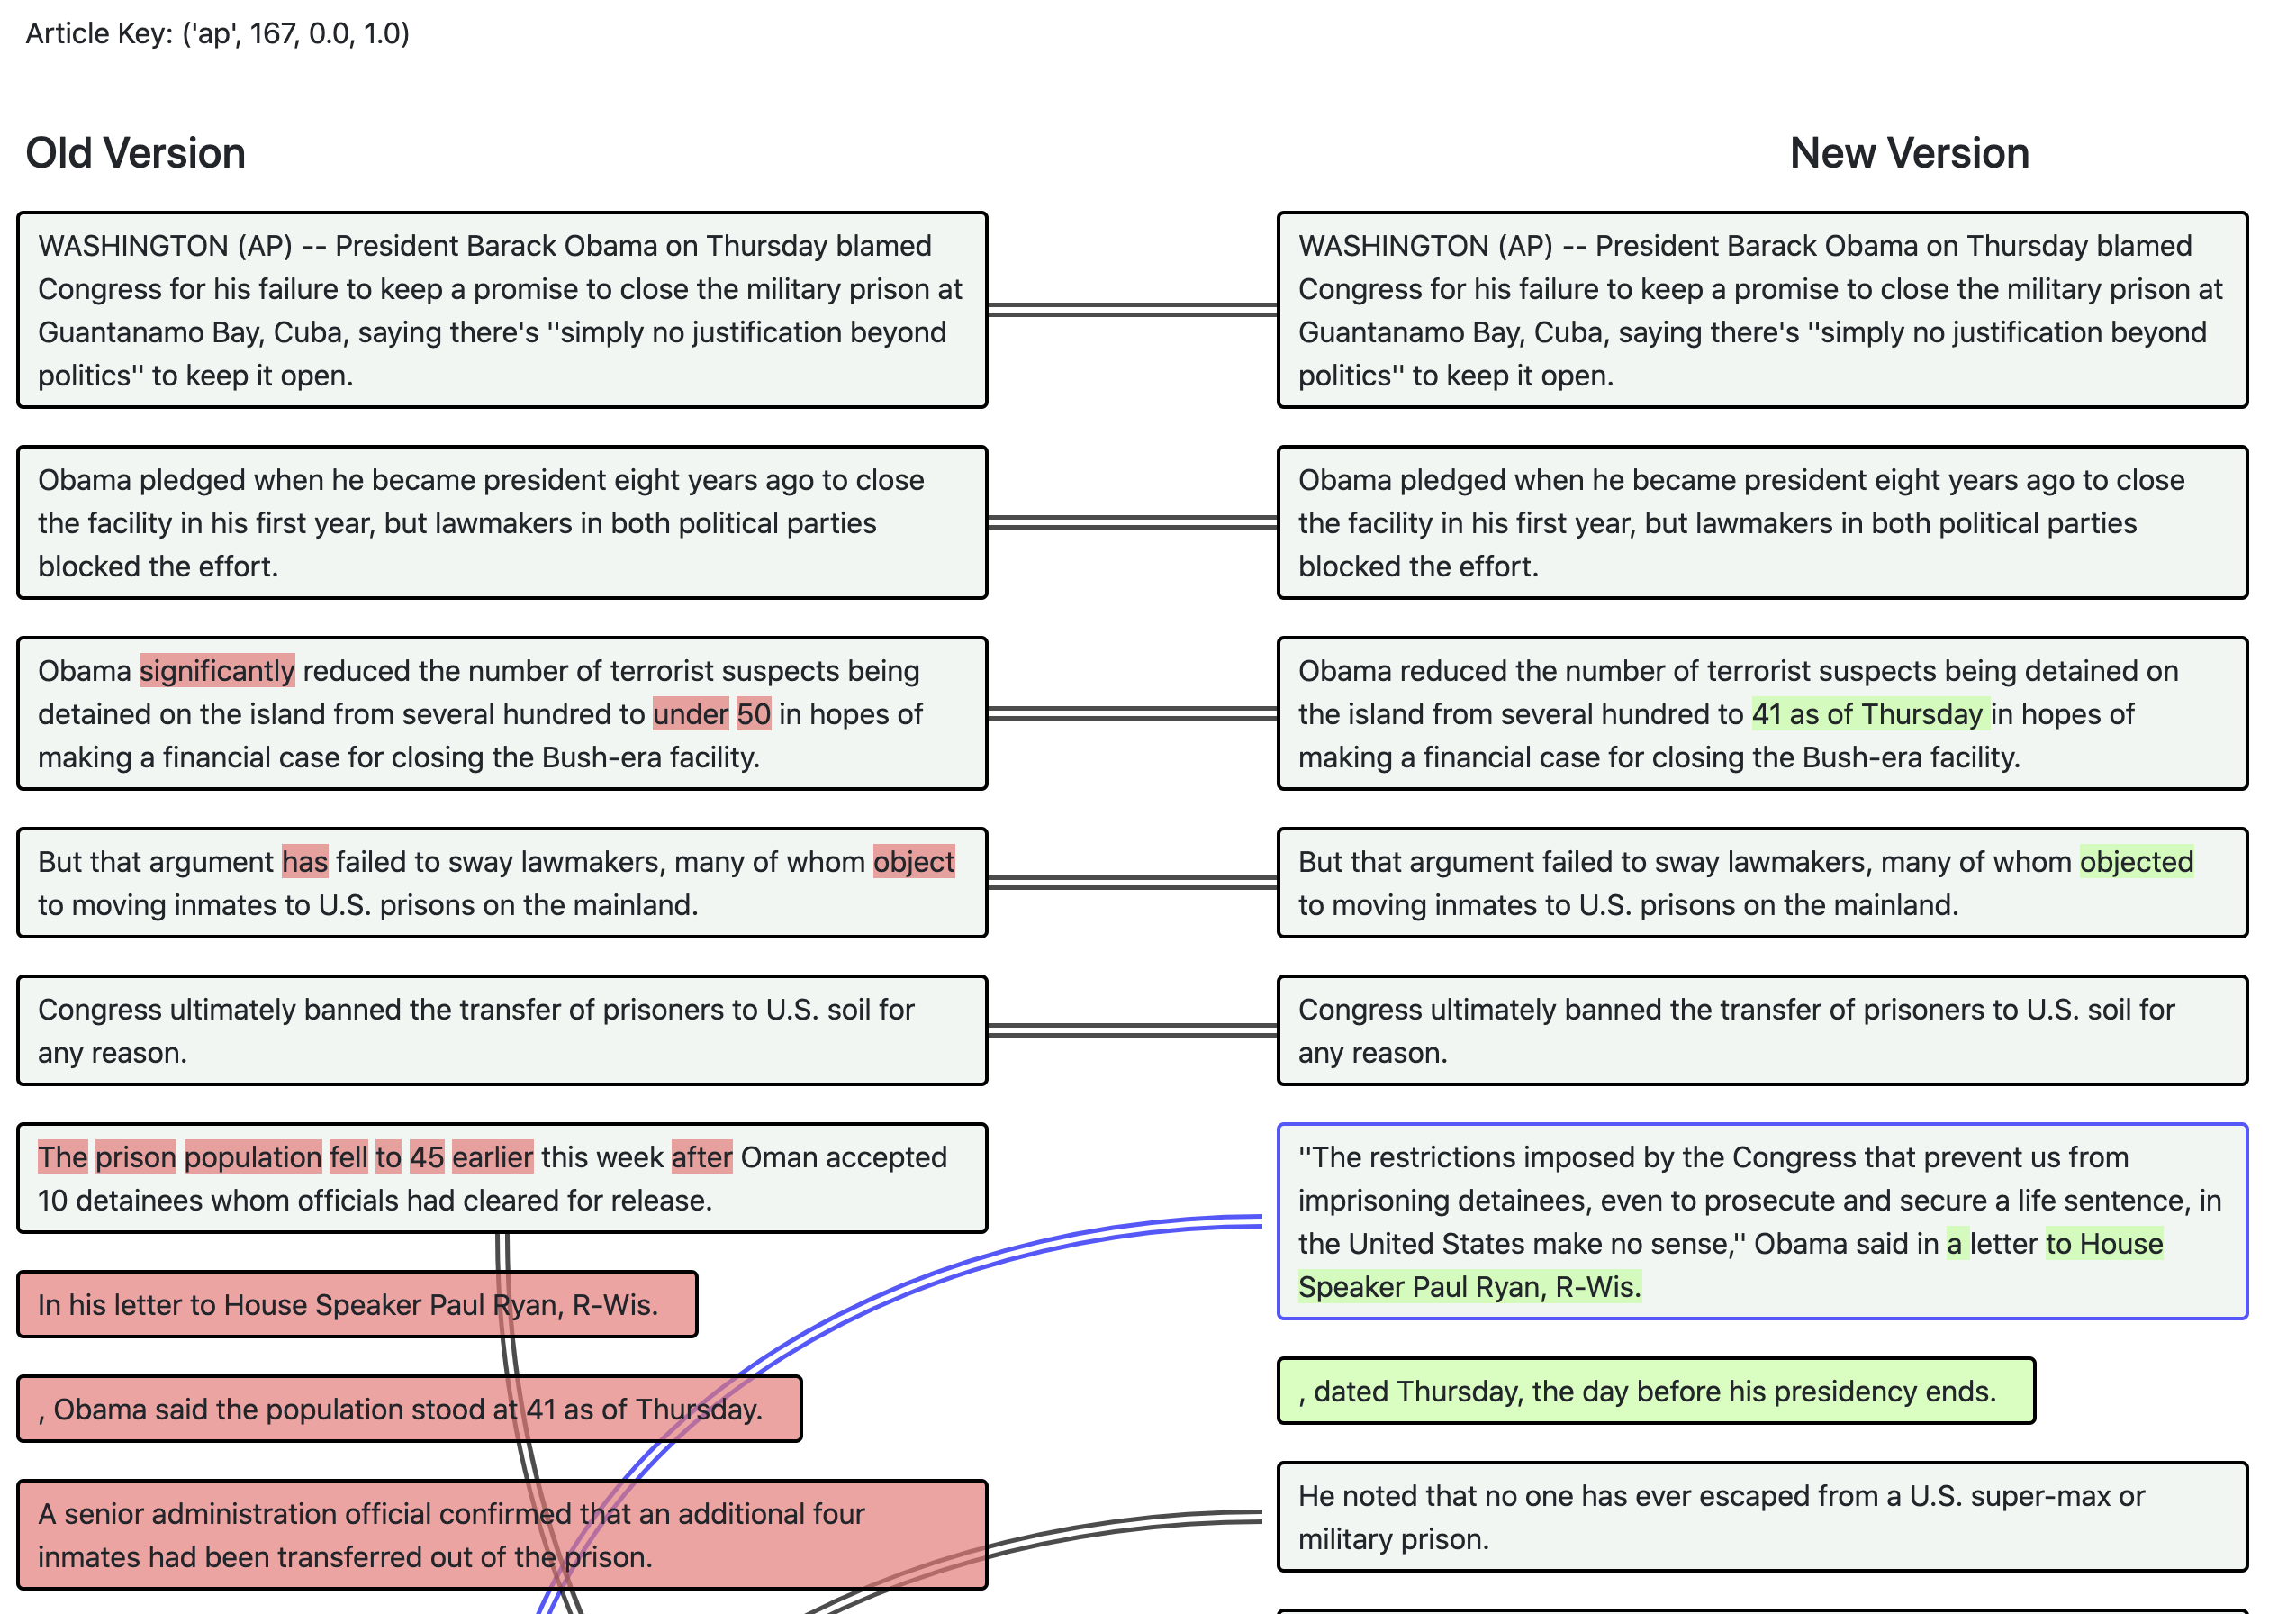

In [176]:
from IPython.display import Image
Image(filename='img/demo-doc-vis.png')

# Calculate Refactors

Supposing we want to dive deeper into refactored sentences, here we show how to run the algorithm described in Appendix F.1, https://aclanthology.org/2022.naacl-main.10.pdf